<a href="https://colab.research.google.com/github/cenkkiran/job-scrape/blob/main/JobListingScraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

First of all we import all the necessary modules

In [2]:
import requests
import urllib.request
import time
from datetime import datetime
import os
import argparse
from bs4 import BeautifulSoup
import pandas as pd
import gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Ngrams allows to group words in common pairs or trigrams..etc
from nltk import ngrams
# We can use counter to count the objects
from collections import Counter
# This is our visual library
import seaborn as sns

In [26]:
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_rows',100)

# Scrape the first node summaries

Let's get our hands dirty and deal with pagination. We'll gather all data into Pandas DataFrame by loops and then write them into Google Sheet.



In [4]:

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [5]:
# Feature set
columns = ['Reference','Title','Salary','Location','Desc','Author','URL','Expired','Date']

# Google Drive Authentication and Google Sheets implementation
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/167_olmhOGFikR6tffGDHSvNR0zcaBq3wWfScZKI6KUg/edit#gid=0')
sheet = wb.worksheet('List')

# Get the data for our pandas DataFrame
data = sheet.get_all_values()
del data[0]
if len(data):
  df = pd.DataFrame(data)
else:
  df= pd.DataFrame(pd.np.empty((0, 9)))
df.columns = columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


In [ ]:
df.head()

In [52]:
condition = True
page = 1
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

while (condition):
 # url = 'https://www.harnham.com/jobs?options=1035,261&page=' + str(page) + '&size=24'
  url = 'https://www.harnham.com/jobs?options=&page=' + str(page) + '&size=60'
  response = requests.get(url, headers=headers)
  soup = BeautifulSoup(response.content, 'html.parser')
  print(response.status_code)
  if not soup.find('p', class_='search-no-results'):
    mydivs = soup.find_all("div", class_="job-block-wrapper")

    for job in mydivs:
      title = job.find('span', class_='inner-title').text.strip()
      salary = job.find('p', class_='salary-text').text.strip().split()
      location = job.find('p', class_='location-text').text.strip().split(',')
      desc = job.find('p', class_='description-text').text.strip().replace('\n',' ')
      reference = job.find('p', class_='job-block__reference-text').text.strip()
      author = job.find('div', class_='job-author-name').text.strip().replace('\n','').split('Author')
      url = 'https://www.harnham.com' + job.find('a', class_='job-block__learnmore-link')['href']
      exp = job.find('time-until')['datetime'].replace('.','')
      synced = datetime.today().strftime('%d/%m/%Y')
      dict = {'Reference' : reference, 'Title': title, 'Salary' : salary[2], 'Location' : location[0], 'Desc' : desc, 'Author' : author[1].strip(), 'URL' : url, 'Expired' : exp, 'Date': synced}

      if not reference in df.values:
        df = df.append(dict, ignore_index=True)
      else:
        print( ' Duplicate ')
        condition = False
        break
  else:
    print( ' no page ')
    condition = False
  page += 1
      
# Still got the duplicates!

200
 Duplicate 


In [53]:
# Let's update our Google Sheets with the updated data.

for index, row in df.iterrows():
  sheet.append_row(list(row))


# Job Details

In [ ]:
# We are going deep into all URL that we gathered and scrape them as well!
text = ''
for link in df.loc[:,'URL']:
  response = requests.get(link, headers=headers)
  soup = BeautifulSoup(response.content, 'html.parser')
  context = soup.find('div', class_='description-widget').find_all(['p','li'])
  text += soup.title.get_text().split('|')[0].replace('\n', '')
  for p in context:
    if "<strong>" in str(p):
      continue
    t = p.get_text()
    t = re.sub(r'==.*?==+', '', t)
    t = t.replace('\n', '')
    t = t.replace('&','')
    t = t.replace(',','')
    print(t)
    text += t
  time.sleep(0.2)

In [57]:
f = open("allcontext.txt", "w")
f.write(text)
f.close()

In [61]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))

# View a few words from the set
list(stops)[0:10]

words = text.split()
words = [word.lower() for word in words]
words = [w for w in words if w not in sw]
words = [w for w in words if w not in list(stops)]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
list(stops)[0:10]

['after', "wouldn't", 're', 'both', "she's", 'her', 'those', 'he', 'ma', 'don']

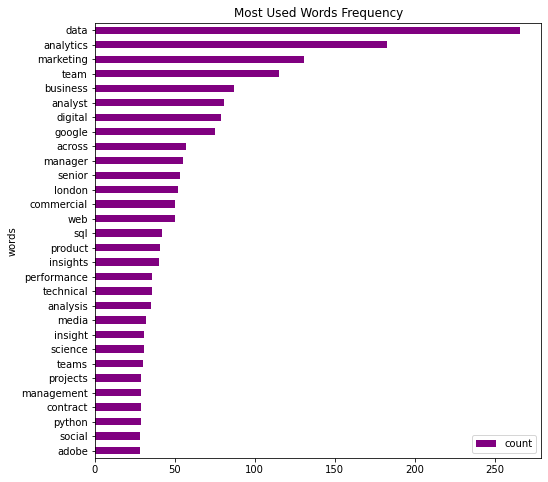

In [62]:
# Create counter
counts_words = Counter(words)
words_df = pd.DataFrame(counts_words.most_common(30), columns=['words', 'count'])
words_df.set_index('words')

fig, ax = plt.subplots(figsize=(8, 8))
words_df.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Used Words Frequency")
plt.show()

In [28]:
words_df = words_df.sort_values('count', ascending=False)
words_df

,words,count


In [60]:
sw = ['a', 'about', 'above', 'across', 'after', 'afterwards']
sw = ['|', 'successful', 'leading', 'lead', 'after', 'afterwards']
sw += ['again', 'against', 'all', 'almost', 'alone', 'along']
sw += ['voof', 'naar', 'sending', 'join', 'seekin', 'client','based','understanding']
sw += ['previous', 'dan', 'ervaring', 'confident','experience','apdracht','multiple','clicking']
sw += ['company', 'customer', 'specialist', 'looking', 'skills']
sw += ['strong', 'understanding', 'stakeholders', 'looking', 'skills']
sw += ['te', 'op', 'cv', '-','deze','het','job','met','van','en','je', 'alone', 'along']
sw += ['already', 'also', 'although', 'always', 'am', 'among']
sw += ['zal', 'jij', 'role', 'work', 'een', 'among','apply','key']
sw += ['amongst', 'amoungst', 'amount', 'an', 'and', 'another']
sw += ['any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere']
sw += ['are', 'around', 'as', 'at', 'back', 'be', 'became']
sw += ['because', 'become', 'becomes', 'becoming', 'been']
sw += ['before', 'beforehand', 'behind', 'being', 'below']
sw += ['beside', 'besides', 'between', 'beyond', 'bill', 'both']
sw += ['bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant']
sw += ['co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de']
sw += ['describe', 'detail', 'did', 'do', 'done', 'down', 'due']
sw += ['during', 'each', 'eg', 'eight', 'either', 'eleven', 'else']
sw += ['elsewhere', 'empty', 'enough', 'etc', 'even', 'ever']
sw += ['every', 'everyone', 'everything', 'everywhere', 'except']
sw += ['few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first']
sw += ['five', 'for', 'former', 'formerly', 'forty', 'found']
sw += ['four', 'from', 'front', 'full', 'further', 'get', 'give']
sw += ['go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her']
sw += ['here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers']
sw += ['herself', 'him', 'himself', 'his', 'how', 'however']
sw += ['hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed']
sw += ['interest', 'into', 'is', 'it', 'its', 'itself', 'keep']
sw += ['last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made']
sw += ['many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine']
sw += ['more', 'moreover', 'most', 'mostly', 'move', 'much']
sw += ['must', 'my', 'myself', 'name', 'namely', 'neither', 'never']
sw += ['nevertheless', 'next', 'nine', 'no', 'nobody', 'none']
sw += ['noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of']
sw += ['off', 'often', 'on','once', 'one', 'only', 'onto', 'or']
sw += ['other', 'others', 'otherwise', 'our', 'ours', 'ourselves']
sw += ['out', 'over', 'own', 'part', 'per', 'perhaps', 'please']
sw += ['put', 'rather', 're', 's', 'same', 'see', 'seem', 'seemed']
sw += ['seeming', 'seems', 'serious', 'several', 'she', 'should']
sw += ['show', 'side', 'since', 'sincere', 'six', 'sixty', 'so']
sw += ['some', 'somehow', 'someone', 'something', 'sometime']
sw += ['sometimes', 'somewhere', 'still', 'such', 'system', 'take']
sw += ['ten', 'than', 'that', 'the', 'their', 'them', 'themselves']
sw += ['then', 'thence', 'there', 'thereafter', 'thereby']
sw += ['therefore', 'therein', 'thereupon', 'these', 'they']
sw += ['thick', 'thin', 'third', 'this', 'those', 'though', 'three']
sw += ['three', 'through', 'throughout', 'thru', 'thus', 'to']
sw += ['together', 'too', 'top', 'toward', 'towards', 'twelve']
sw += ['twenty', 'two', 'un', 'under', 'until', 'up', 'upon']
sw += ['us', 'very', 'via', 'was', 'we', 'well', 'were', 'what']
sw += ['whatever', 'when', 'whence', 'whenever', 'where']
sw += ['whereafter', 'whereas', 'whereby', 'wherein', 'whereupon']
sw += ['wherever', 'whether', 'which', 'while', 'whither', 'who']
sw += ['whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with']
sw += ['within', 'without', 'would', 'yet', 'you', 'your']
sw += ['yours', 'yourself', 'yourselves','register','CV','Apply']
sw += ['link', 'page', 'andrew','please','Denham','English','Fluent']
sw += ['zavina','johnson','Elizabeth','stone','working','using','site','alongside','opportunity']
# sw += [n for n in list(df['Author'])]
